## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import view
import numpy as np

In [2]:
pwd

'/home/micromamba/pixel/pixeloffset_mintpy'

In [3]:
mkdir /home/micromamba/pixel/poroa/autorift/mintpy

In [4]:
cd /home/micromamba/pixel/poroa/autorift/mintpy

/home/micromamba/pixel/poroa/autorift/mintpy


## Run MintPy

### Load Data

In [5]:
cp /home/micromamba/pixel/pixeloffset_mintpy/autorift.cfg ./autorift.cfg

In [7]:
!load_data.py -t ./autorift.cfg

processor : cosicorr
SAR platform/sensor : unknown from project name "None"
--------------------------------------------------
prepare metadata files for cosicorr products
prep_cosicorr.py /home/micromamba/pixel/poroa/autorift/*NSOffset.tif --metadata /home/micromamba/pixel/poroa/autorift/metadata.txt
prep_cosicorr.py /home/micromamba/pixel/poroa/autorift/*EWOffset.tif --metadata /home/micromamba/pixel/poroa/autorift/metadata.txt
--------------------------------------------------
searching interferometric pairs info
input data files:
azimuthOffset   : /home/micromamba/pixel/poroa/autorift/*NSOffset.tif
rangeOffset     : /home/micromamba/pixel/poroa/autorift/*EWOffset.tif
number of azimuthOffset   : 15
number of rangeOffset     : 15
--------------------------------------------------
searching geometry files info
input data files:
--------------------------------------------------
updateMode : False
compression: None
x/ystep: 1/1
create directory: /home/micromamba/pixel/poroa/autorift/mi

In [8]:
!info.py inputs/ifgramStack.h5

******************** Basic File Info ************************
file name: /home/micromamba/pixel/poroa/autorift/mintpy/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                   1
  AZIMUTH_PIXEL_SIZE       40.0
  BANDS                    1
  CENTER_LINE_UTC          43200.0
  DATA_TYPE                float32
  DATE12                   20161122-20171122
  EPSG                     32760
  FILE_LENGTH              84
  FILE_PATH                /home/micromamba/pixel/poroa/autorift/autorift_20161122T000000_20171122T000000_EWOffset.tif
  FILE_TYPE                ifgramStack
  INTERLEAVE               BSQ
  LAT_REF1                 5597975.0
  LAT_REF2                 5597975.0
  LAT_REF3                 5601335.0
  LAT_REF4                 5601335.0
  LENGTH                   84
  LON_REF1                 399455.0
  LON_REF2                 404815.0
  LON_REF3                

## Take Median

In [9]:
az = readfile.read('inputs/ifgramStack.h5', datasetName='azimuthOffset')[0]
az_median = np.nanmedian(az, axis=(1,2))
az_new = az - az_median[:,None,None]

In [10]:
rg = readfile.read('inputs/ifgramStack.h5', datasetName='rangeOffset')[0]
rg_median = np.nanmedian(rg, axis=(1,2))
rg_new = rg - rg_median[:,None,None]

In [11]:
writefile.write({'azimuthOffset':az_new,'rangeOffset':rg_new},'inputs/ifgramStack_median.h5',ref_file='inputs/ifgramStack.h5')

create HDF5 file: inputs/ifgramStack_median.h5 with w mode
create dataset /azimuthOffset of float32    in size of (15, 84, 134)        with compression=None
create dataset /rangeOffset   of float32    in size of (15, 84, 134)        with compression=None
create dataset /bperp         of float32    in size of (15,)      with compression=None
create dataset /date          of |S8        in size of (15, 2)    with compression=None
create dataset /dropIfgram    of bool       in size of (15,)      with compression=None
finished writing to inputs/ifgramStack_median.h5


'inputs/ifgramStack_median.h5'

### View stack

view.py inputs/ifgramStack.h5 azimuthOffset --noverbose


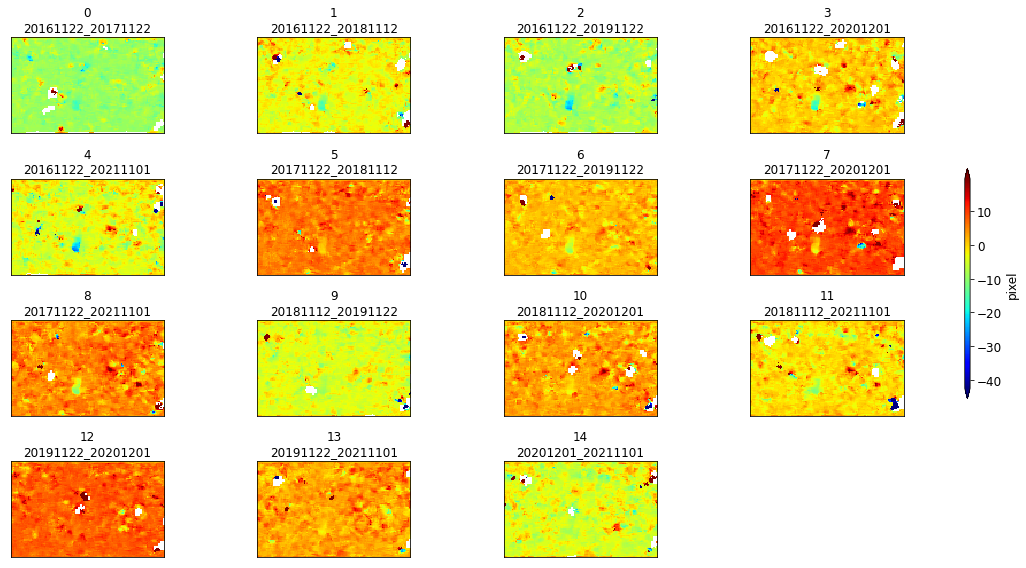

In [12]:
view.main('inputs/ifgramStack.h5 azimuthOffset --noverbose'.split())

view.py inputs/ifgramStack_median.h5 azimuthOffset --noverbose


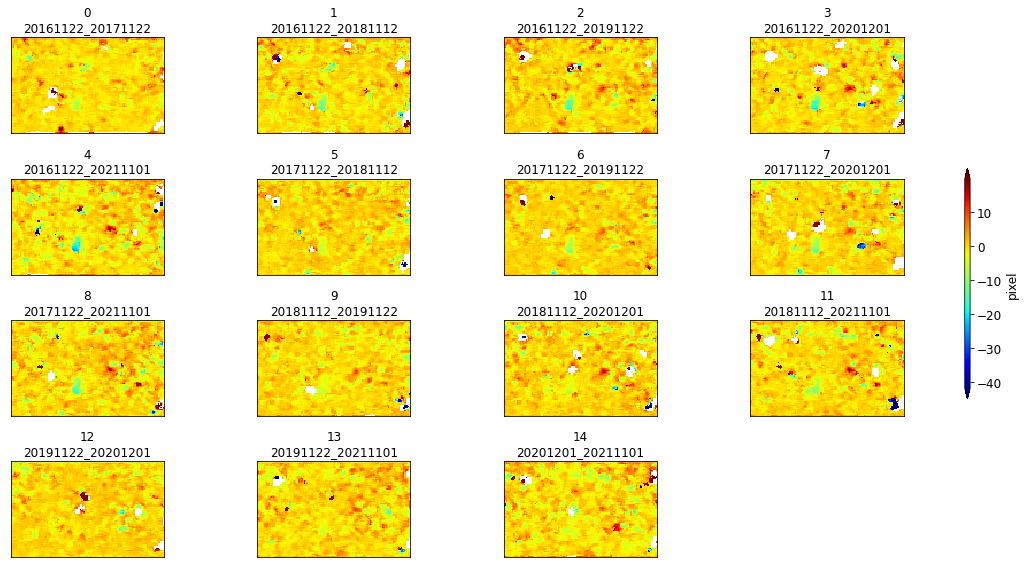

In [13]:
view.main('inputs/ifgramStack_median.h5 azimuthOffset --noverbose'.split())

view.py inputs/ifgramStack_median.h5 rangeOffset --noverbose


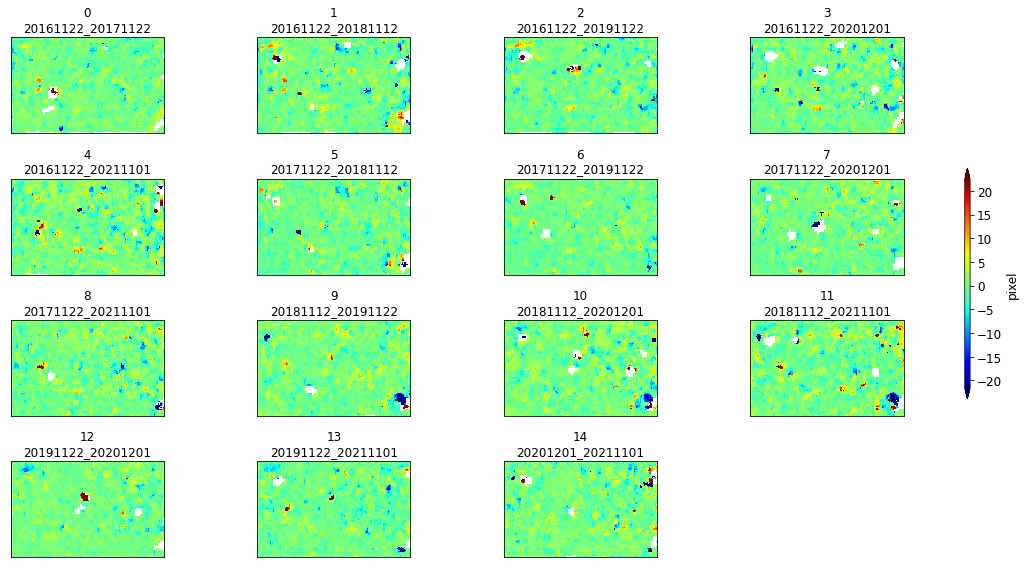

In [14]:
view.main('inputs/ifgramStack_median.h5 rangeOffset --noverbose'.split())

### Inversion

In [15]:
# !ifgram_inversion.py inputs/ifgramStack.h5 -i rangeOffset -w no -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5
# !ifgram_inversion.py inputs/ifgramStack.h5 -i azimuthOffset -w no -o timeseriesAz.h5 residualInvAz.h5 numInvOffsetAz.h5

!ifgram_inversion.py inputs/ifgramStack_median.h5 -i rangeOffset -w no -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5
!ifgram_inversion.py inputs/ifgramStack_median.h5 -i azimuthOffset -w no -o timeseriesAz.h5 residualInvAz.h5 numInvOffsetAz.h5

save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
calculate STD: False 
mask: no
-------------------------------------------------------------------------------
number of interferograms: 15
number of acquisitions  : 6
number of lines   : 84
number of columns : 134
--------------------------------------------------
create HDF5 file: timeseriesRg.h5 with w mode
create dataset  : date       of |S8                       in size of (6,)                 with compression = None
create dataset  : bperp      of <

### Remove ramp

In [16]:
# !remove_ramp.py timeseriesAz.h5 -s linear -o timeseriesAz_ramp.h5 --save-ramp-coeff
# !remove_ramp.py timeseriesRg.h5 -s linear -o timeseriesRg_ramp.h5 --save-ramp-coeff

### timeseries2velocity

In [17]:
!timeseries2velocity.py timeseriesAz.h5 -o velocityAz.h5 --bootstrap --bc 100
!timeseries2velocity.py timeseriesRg.h5 -o velocityRg.h5 --bootstrap --bc 100

bootstrapping is turned ON.
open timeseries file: timeseriesAz.h5
--------------------------------------------------
dates from input file: 6
['20161122', '20171122', '20181112', '20191122', '20201201', '20211101']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'bootstrap', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocityAz.h5 with w mode
create dataset  : velocity    of <class 'numpy.float32'>   in size of (84, 134)            with compression = None
create dataset  : velocityStd of <class 'numpy.float32'>   in size of (84, 134)            with compression = None
add /velocity    attribute:

## View results

### Azimuth

view.py velocityAz.h5 --vlim -750 750 --noverbose


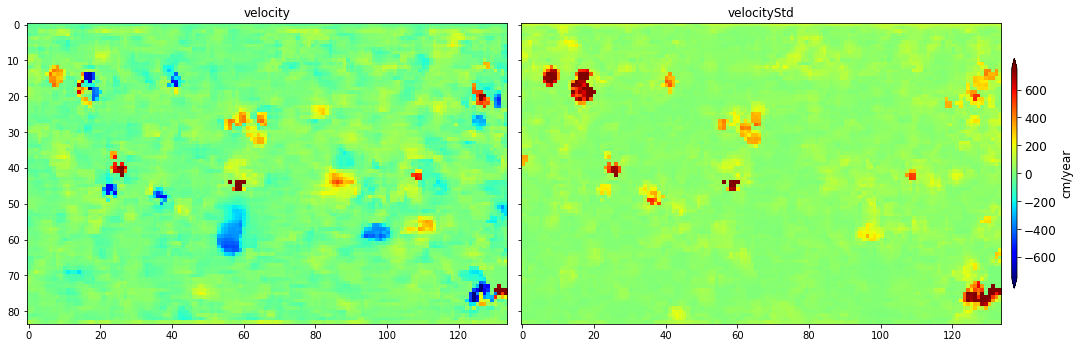

In [18]:
view.main('velocityAz.h5 --vlim -750 750 --noverbose'.split())

## Range

view.py velocityRg.h5 --vlim -750 750 --noverbose


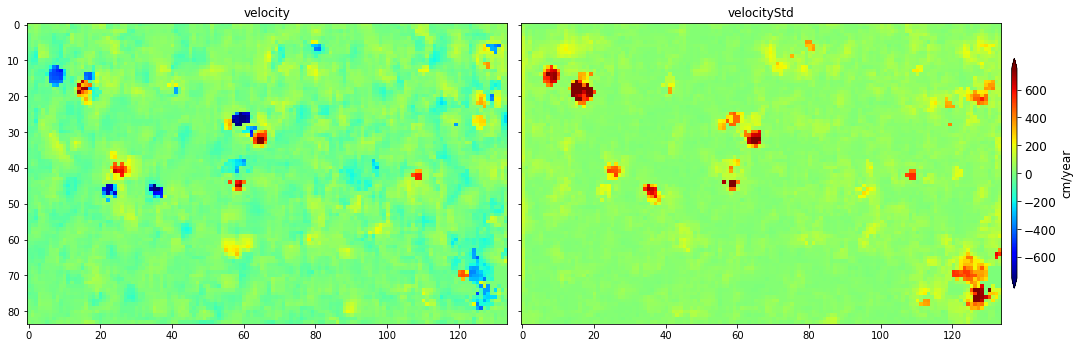

In [19]:
view.main('velocityRg.h5 --vlim -750 750 --noverbose'.split())